# 파이토치 MNIST 모델

## modules import 

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 전처리 설정
- `transform.Compose`

In [104]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5),(0.5))])

## 데이터 로드 및 데이터 확인

In [105]:
trainset = torchvision.datasets.MNIST(root = "./data",
                                      train=True,
                                      download=True,
                                      transform=transform)
testset = torchvision.datasets.MNIST(root = "./data",
                                      train=0,
                                      download=True,
                                      transform=transform)

In [106]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)#num_workers 에러가 나오기도 한다.

In [107]:
image , label = next(iter(train_loader))

In [108]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [109]:
def imshow(img):
    img = img /2 +0.5
    npimg = img.numpy()
    fig =plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

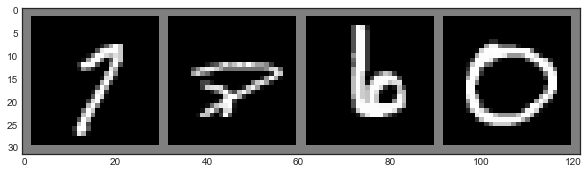

In [110]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [111]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6,3)#input -1, output - 6, kernel - 3
        self.conv2 = nn.Conv2d(6,16,3)#input -6, output - 16, kernel - 3
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        # print(size)
        num_features=1
        for s in size:
            num_features*=s
            
        return num_features
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [112]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [113]:
input = torch.randn(1,1,28,28).to(device)
out = net(input).to(device)
print(out)

tensor([[ 0.0356,  0.1468,  0.0648, -0.0336,  0.0117,  0.0264, -0.1112, -0.0853,
          0.0556, -0.1046]], device='cuda:0', grad_fn=<AddmmBackward0>)


## 손실함수와 옵티마이저

In [114]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr= 0.001,momentum=0.9)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [115]:
total_batch = len(train_loader)
print(total_batch)

469


In [116]:
print(torch.cuda.is_available())

True


- 설명을 위해 `epochs=2`로 지정

In [138]:
def main():
    epochs = 2
    for epoch in range(epochs):
        running_loss = 0.0  
        for i,data in enumerate(train_loader,0):
            inputs , labels = data
            inputs , labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            running_loss +=loss.item()
            if i %100 ==99:
                print(f"epoch : {epoch+1}, Iter : {i+1}, loss: {running_loss/2000}")#loss 이게 맞나?
                running_loss = 0.0
if __name__ =="__main__":
    main()

epoch : 1, Iter : 100, loss: 0.01703944132477045
epoch : 1, Iter : 200, loss: 0.016215096466243268
epoch : 1, Iter : 300, loss: 0.015063747502863408
epoch : 1, Iter : 400, loss: 0.013917072728276253
epoch : 2, Iter : 100, loss: 0.012705181170254945
epoch : 2, Iter : 200, loss: 0.011856597021222114
epoch : 2, Iter : 300, loss: 0.011369917888194322
epoch : 2, Iter : 400, loss: 0.010661920260637999


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [118]:
path ="./mnist_net.pth"
torch.save(net.state_dict(),path)

In [119]:
net = Net()

In [120]:
net.load_state_dict(torch.load(path))

<All keys matched successfully>

## 모델 테스트

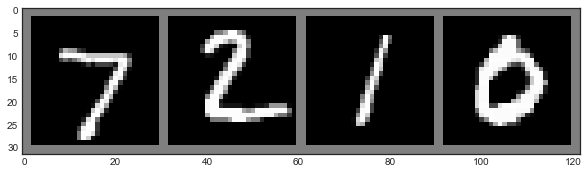

In [121]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [122]:
outputs = net(images).to(device)

In [123]:
_,predicted = torch.max(outputs,1)
print(outputs)
print(_)
print(predicted)

tensor([[-2.7394, -0.2433, -2.8940,  ...,  5.4610,  0.9091,  3.0823],
        [ 2.8221,  0.8855,  6.9035,  ..., -6.6446,  3.3905, -5.7299],
        [-3.7975,  3.9899, -0.1820,  ...,  0.5423,  1.3673, -0.4811],
        ...,
        [-2.7692, -0.0582, -1.1507,  ...,  0.3725,  1.7377,  2.1025],
        [ 5.1640, -5.8482,  2.7671,  ..., -0.1249,  1.3139, -0.8403],
        [ 0.9976, -2.0461, -2.4237,  ...,  0.3086,  2.5641,  1.8660]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([ 5.4610,  6.9035,  3.9899,  7.4013,  4.8635,  5.7252,  4.5608,  3.9504,
         3.7893,  5.4960,  8.8348,  2.4285,  4.7046,  7.3520,  5.8739,  3.0380,
         4.1738,  6.0190,  3.8447,  5.2562,  5.1448,  5.6271,  3.1744,  2.8764,
         2.8520, 11.0452,  4.1776,  6.2991,  6.2877,  3.9047,  4.0048,  3.3341,
         3.5371,  6.1055,  3.4595,  7.4491,  5.2527,  4.6340,  4.7812,  5.6848,
         2.5709,  4.0646,  5.9280,  3.9360,  3.1657,  2.5071,  2.6138,  2.9967,
         7.1271,  6.9029,  4.5336, 

In [124]:
predicted = predicted.to("cpu")

print(" ".join(str(predicted.numpy())))

[ 7   2   1   0   4   1   9   9   6   9   0   6   4   0   1   3   4   7   3   4   9   6   4   5   4   0   7   4   0   1   3   1   3   0   7   2   7 
   1   2   1   1   7   4   2   3   5   1   2   4   4   6   3   5   5   6   0   4   1   4   7   7   8   4   3   7   4   8   4   3   0   7   0   2   8 
   1   7   3   7   9   7   9   6   2   7   8   4   7   3   6   1   3   6   4   3   1   4   1   7   6   9   6   0   5   4   9   4   2   1   9   4   8 
   1   3   9   7   4   4   4   4   8   5   4   7   6   7   9   0   5 ]


In [125]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # images, labels = images.to(device), labels.to(device)
        # print(type(images))
        # print(type(labels))
        # input()
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct +=(predicted ==labels).sum().item()
print(100*correct/total)

79.27


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")



- 현재 GPU 설정

In [129]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [130]:
print(device)

cuda


- 데이터 로드


In [131]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5),(0.5))])

trainset = torchvision.datasets.MNIST(root = "./data",
                                      train=True,
                                      download=True,
                                      transform=transform)
testset = torchvision.datasets.MNIST(root = "./data",
                                      train=0,
                                      download=True,
                                      transform=transform)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)#num_workers 에러가 나오기도 한다.

- 모델 생성

In [132]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6,3)#input -1, output - 6, kernel - 3
        self.conv2 = nn.Conv2d(6,16,3)#input -6, output - 16, kernel - 3
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        # print(size)
        num_features=1
        for s in size:
            num_features*=s
            
        return num_features
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [133]:
net = Net().to(device)

In [134]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr= 0.001,momentum=0.9)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [140]:
# def main():
epochs = 2
for epoch in range(epochs):
    running_loss = 0.0  
    for i,data in enumerate(train_loader,0):
        inputs , labels = data
        # 아래와 같이 대체 가능
        # inputs , labels = data[0].to(device), data[1].to(device)
        inputs , labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step( )
        
        running_loss +=loss.item()
        if i %100 ==99:
            print(f"epoch : {epoch+1}, Iter : {i+1}, loss: {running_loss/2000}")#loss 이게 맞나?
            running_loss = 0.0
# if __name__ =="__main__":
#     main()

epoch : 1, Iter : 100, loss: 0.009931439373642206
epoch : 1, Iter : 200, loss: 0.009149244874715806
epoch : 1, Iter : 300, loss: 0.009160273123532533
epoch : 1, Iter : 400, loss: 0.008614410225301981
epoch : 2, Iter : 100, loss: 0.007901326533406973
epoch : 2, Iter : 200, loss: 0.00781743205524981
epoch : 2, Iter : 300, loss: 0.007625415502116084
epoch : 2, Iter : 400, loss: 0.007153895076364279


In [141]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # images, labels = images.to(device), labels.to(device)
        # print(type(images))
        # print(type(labels))
        # input()
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct +=(predicted ==labels).sum().item()
print(100*correct/total)

96.24
